Задание №3. Метод опорных  векторов
--
Выполнила : Соболева Дарья
--
    
Студентка 317 группы ВМК МГУ
--
Версия Python 2.7
--

In [2]:
import time
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import accuracy_score
from IPython.display import display
import time

from svm import SVM, visualize

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [409]:
def cross_val_score(data, y, clf, n_fold):
    
    kf = KFold(data.shape[0], n_fold)
    score = []
    
    for i, j in kf:
        train, test  = data[i, :], data[j, :]
        y_train, y_test = y[i], y[j]
        
        clf.fit(train, y_train)
        
        score.append(
           accuracy_score(
             y_test,
             clf.predict(
                test,
                return_classes=True)))
        
    return np.mean(score)

In [172]:
def simple_search(data, y, method, kernel, C_list, gamma_list):
    
    print('Method: {}'.format(method))
    print('-------------------------')
    scores_ = []
    best_score = -np.inf
    
    for C in C_list:
        for gamma in gamma_list:
            clf = SVM(C=C, method=method, kernel=kernel, gamma=gamma)
    
            score = cross_val_score(data, y, clf, 5)
            if score > best_score:
                best_score = score
                best_C = C
                best_gamma = gamma
             
            scores_.append({'C': C, 'gamma' : gamma, 'mean': score})
            #print("mean: {} |     params: ['C': {}, 'gamma': {}]".format(score, C, gamma))
    
    display(pd.DataFrame(scores_).T)
    
    return {'C' : best_C, 
            'gamma' : best_gamma, 
            'Accuracy' : best_score}

# Теоритическая часть

Необходимо было построить линейный классификатор при помощи метода опорных векторов для задачи двухклассовой классификации.

Проводилась реализация прямой и двойственной задач SVM.


###  Прямая задача SVM

$$\min_{\omega, \xi \geq 0} \frac{1}{2} \lVert \omega \rVert ^ 2 + C\sum^{N}_{n=1} {\xi_n} $$
$$ s.t. y_n (\omega^T x_n + \omega_0) \geq 1 - \xi_n,  n = 1, ..., N $$

### Прямая задача SVM без ограничений

$$\min_{\omega, \xi \geq 0} \frac{1}{2} \lVert \omega \rVert ^ 2 + C\sum^{N}_{n=1} \max_{}(0, 1- y_n(\omega^T x_n + \omega_0))$$

Необходимо найти: 
    
Параметры $\omega \in R^D, \omega_0 \in R$ линейной модели классификации:
$$a(x) = sign(\omega^T x + \omega_0)$$
    


Рассмотренные методы решения:

* Метод внутренней точки.
* Метод субградиентного спуска.
* Метод стохастического субградиентного спуска.
* Метод, используемый в библиотеке liblinear.

### Двойственная задача SVM

$$ \max_{a} \sum^{N}_{n=1} {a_n} - \frac{1}{2} \sum^{N}_{n=1} \sum^{N}_{m=1} {a_n a_m y_n y_m k(x_n, x_m)}$$
         
$$ s.t. {0 \leq a_n \leq C},  n = 1, ..., N $$
$$      \sum^{N}_{n=1} {a_n y_n} $$

Необходимо найти: 
    
   Параметры $ \lambda_i$: 
    
$$a(x) = sign(\sum^{N}_{n=1} {\lambda_n y_n <x_n, x> } + \omega_0)$$
где $ \omega_0 = -\sum^{N}_{n=1} {\lambda_n y_n <x_n, x_j>} + y_j$ для такого j, что объект с данным номером в обучающей выборке является опорным граничным. 
    
Объект называется опорным, если $\lambda_i \neq 0$.

Понятие опорного граничного объекта вводится на основании типизации объектов в зависимости от значения двойственных переменных.

Опорным граничным объектом будем называть объект с $ {0 \leq \lambda_i \leq C} $.

Рассмотренные методы решения:
* Метод внутренней точки.
* Метод, используемый в библиотеке libsvm.

----

В первой серии экспериментов будут участвовать методы для решения задачи линейного SVM.

Необходимо провести анализ зависимости времени работы работы реализованных методов от:
* Размерности признакового пространства (D).
* Числа объектов в обучающей выборке (N).

Оценить скорость сходимости методов и осуществить сравнение полученных значений целевой функции.

Прежде чем преступить к анализу, проведем краткую характеристику каждого оцениваемого метода: 

* Метод внутренней точки был реализован при помощи библиотеки cvxopt, позволяющей решать задачи квадратичного программирования.


* Метод liblinear использует биндинги из библиотеки sklearn.svm.LinearSVC.


* Метод libsvm использует биндинги из библиотеки sklearn.svm.SVC.


* Метод субградиентного спуска и его стохастический вариант былы реализованы на основании алгоритма, приведенного 

на лекции К.В. Воронцова [Градиентный метод численной минимизации](https://d3c33hcgiwev3.cloudfront.net/_aea44b6407758309ec36a9f1f4084077____________-______-_________-___________-_-________-SG-.pdf?Expires=1478995200&Signature=GiBrk2DF9FuNi8iaBMq6up4ZUgI5jqAospDLUD8zww2451EyyFokBmWAaAyJwkd8CQVPoEKIx1ayOQuaQAdzG4ZE2-zguAiC5fakhrfvuwoTaGVr9Zfq4l7iBIzhT0Q2Uof1ASIGyL~ymdMSTkh4BblVoGhqhzmBgY9kGSYPpzo_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A).

В данной работе был реализован метод, аналогичный градиентному спуску, в котором вместо градиента был использован субградиент.

Обозначим минимизирующий функционал прямой задачи SVM без ограничений через Q.

Тогда субградиентом Q является:

\begin{equation*}
\nabla Q(\omega) = \omega +
 \begin{cases}
   С\sum^{N}_{n=1}{ - y_n x_n},  &\text{$1- y_n(\omega^T x_n + \omega_0) \geq 0$}\\\\
   0, &\text{иначе}
 \end{cases}
\end{equation*}



\begin{equation*}
\nabla Q(\omega_0) = 
 \begin{cases}
   С\sum^{N}_{n=1}{ - y_n}, &\text{$1- y_n(\omega^T x_n + \omega_0) \geq 0$} \\
   0, &\text{иначе}
 \end{cases}
\end{equation*}
 
Критериями останова могут служить либо значение целевой функции, либо норма вектора весов.

Субградиентные методы используют некоторые эвристики для оценки функционала.

Обычный субградиентный метод вычисляет итерационную формулу среднего арифметического.

$Q_m = (1 - \frac{1}{m}) Q_{m-1} + \frac{1}{m} \varepsilon_m,  \varepsilon_m $ - средняя потеря на  всех объектах.

Стохастический вариант - экспонециально скользящее среднее.

$Q_m = (1 - \lambda) Q_{m-1} + \lambda \varepsilon_m,  \varepsilon_m $ - средняя потеря на случайно выбранном подмножестве
объектов.



# Эксперименты

Для проведения исследований были взяты модельные данные из многомерного нормального распределения.

Зафиксируем число объектов в обучающей выборке и оценим зависимость времени работы реализованных методов от размерности признакового пространства.

Каждая модель будет рассмотрена с установленными параметрами по умолчанию, более детальное описание каждого из которых можно
найти в документации к классу SVM. 

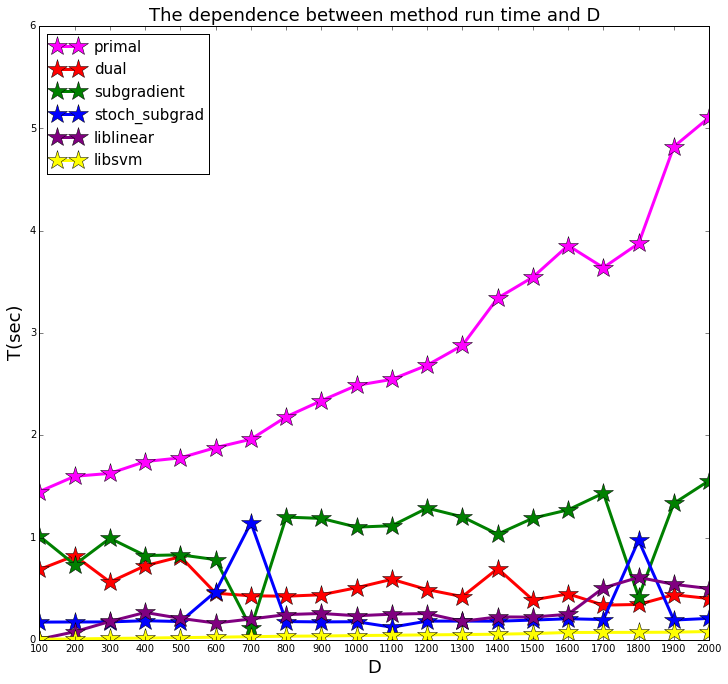

In [12]:
N = 200
D_list = list(range(100, 2100, 100))
y = np.random.choice([-1, 1], size=N)

clf_primal = SVM(method='primal')
clf_dual = SVM(method='dual', kernel='linear')
clf_subgrad = SVM(method='subgradient')
clf_stoch_subgrad = SVM(method='stoch_subgradient')
clf_liblinear = SVM(method='liblinear')
clf_libsvm = SVM(method='libsvm', kernel='linear')

time_ = {}
time_['primal'] = []
time_['dual'] = []
time_['subgrad'] = []
time_['stoch_subgrad'] = []
time_['liblinear'] = []
time_['libsvm'] = []

for D in D_list:
    mean = np.zeros(D)
    cov = np.eye(D)
    data = np.random.multivariate_normal(mean, cov, N)
    
    start = time.clock()
    clf_primal.fit(data, y)
    time_['primal'].append(time.clock()-start)
    
    start = time.clock()
    clf_dual.fit(data, y)
    time_['dual'].append(time.clock()-start)
    
    start = time.clock()
    clf_subgrad.fit(data, y)
    time_['subgrad'].append(time.clock()-start)
    
    start = time.clock()
    clf_stoch_subgrad.fit(data, y)
    time_['stoch_subgrad'].append(time.clock()-start)
    
    start = time.clock()
    clf_liblinear.fit(data, y)
    time_['liblinear'].append(time.clock()-start)
    
    start = time.clock()
    clf_libsvm.fit(data, y)
    time_['libsvm'].append(time.clock()-start)
    
figure(figsize=(12,11))
plot(D_list, time_['primal'],  lw = 3, marker='*', markersize=20, color = 'magenta')
plot(D_list, time_['dual'],    lw = 3, marker='*', markersize=20, color = 'red')
plot(D_list, time_['subgrad'], lw = 3, marker='*', markersize=20, color = 'green')
plot(D_list, time_['stoch_subgrad'], lw = 3, marker='*', markersize=20, color = 'blue')
plot(D_list, time_['liblinear'], lw = 3, marker='*', markersize=20, color = 'purple')
plot(D_list, time_['libsvm'], lw = 3, marker='*', markersize=20, color = 'yellow')

#xscale('log')
legend(['primal', 'dual', 'subgradient','stoch_subgrad','liblinear', 'libsvm'], loc = 'upper left', fontsize = 15)
xlabel("D", fontsize = 18)
xlim([min(D_list), max(D_list)])
xticks(np.arange(min(D_list), max(D_list)+1, 100))
ylabel('T(sec)', fontsize = 18)
title('The dependence between method run time and D', fontsize = 18)
show()

Прямые методы достаточно чувствительны к размерности признакового пространства.

Наиболее показательным примером данной особенности прямых методов является метод primal.

Наблюдается квадратичная зависимость.

Двойственные методы слабо зависят от числа признаков.
Действительно, подсчет матрицы Грамма для двойственной задачи осуществляется единожды. Далее нигде сложность задачи не возникает.


В следующем эксперименте зафиксируем число признаков и оценим зависимость времени работы реализованных методов от числа объектов в обучающей выборке.

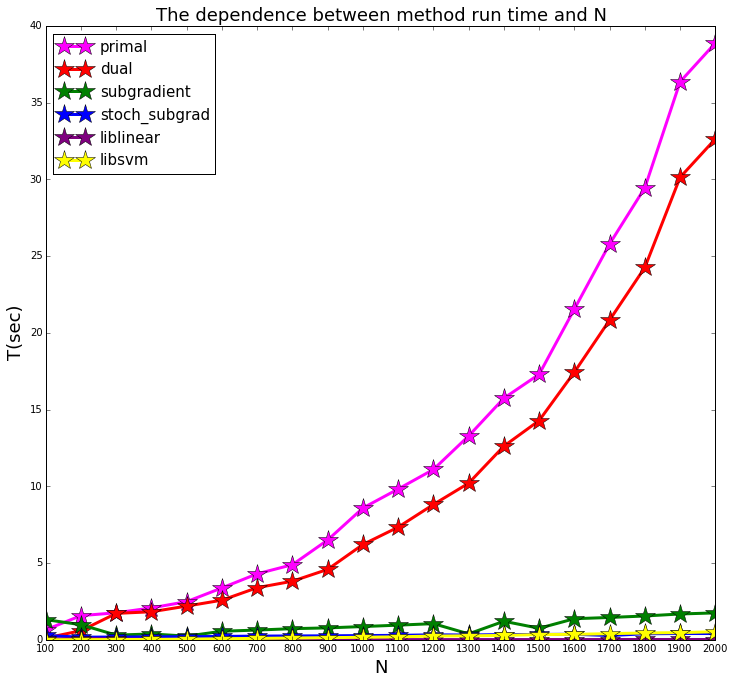

In [13]:
D = 200
mean = np.zeros(D)
cov = np.eye(D)
N_list = list(range(100, 2100, 100))

clf_primal = SVM(method='primal')
clf_dual = SVM(method='dual', kernel='linear')
clf_subgrad = SVM(method='subgradient')
clf_stoch_subgrad = SVM(method='stoch_subgradient')
clf_liblinear = SVM(method='liblinear')
clf_libsvm = SVM(method='libsvm', kernel='linear')

time_ = {}
time_['primal'] = []
time_['dual'] = []
time_['subgrad'] = []
time_['stoch_subgrad'] = []
time_['liblinear'] = []
time_['libsvm'] = []

for N in N_list:
    data = np.random.multivariate_normal(mean, cov, N)
    y = np.random.choice([-1, 1], size=N)
    
    start = time.clock()
    clf_primal.fit(data, y)
    time_['primal'].append(time.clock()-start)
    
    start = time.clock()
    clf_dual.fit(data, y)
    time_['dual'].append(time.clock()-start)
    
    start = time.clock()
    clf_subgrad.fit(data, y)
    time_['subgrad'].append(time.clock()-start)
    
    start = time.clock()
    clf_stoch_subgrad.fit(data, y)
    time_['stoch_subgrad'].append(time.clock()-start)
    
    start = time.clock()
    clf_liblinear.fit(data, y)
    time_['liblinear'].append(time.clock()-start)
    
    start = time.clock()
    clf_libsvm.fit(data, y)
    time_['libsvm'].append(time.clock()-start)
    
figure(figsize=(12,11))
plot(N_list, time_['primal'],  lw = 3, marker='*', markersize=20, color = 'magenta')
plot(N_list, time_['dual'],    lw = 3, marker='*', markersize=20, color = 'red')
plot(N_list, time_['subgrad'], lw = 3, marker='*', markersize=20, color = 'green')
plot(N_list, time_['stoch_subgrad'], lw = 3, marker='*', markersize=20, color = 'blue')
plot(N_list, time_['liblinear'], lw = 3, marker='*', markersize=20, color = 'purple')
plot(N_list, time_['libsvm'], lw = 3, marker='*', markersize=20, color = 'yellow')

#xscale('log')
legend(['primal', 'dual', 'subgradient','stoch_subgrad','liblinear', 'libsvm'], loc = 'upper left', fontsize = 15)
xlabel("N", fontsize = 18)
xticks(np.arange(min(N_list), max(N_list)+1, 100))
xlim([min(N_list), max(N_list)])
ylabel('T(sec)', fontsize = 18)
title('The dependence between method run time and N', fontsize = 18)
show()

Двойственные методы чувствительны к числу объектов в обучающей выборке.

Показательным примером является метод dual.

Наблюдается квадратичная зависимость.

Исследуем скорость сходимости субградиентных методов. Оценим методы по полученным значениям целевой функции.

Под скоростью сходимости будем понимать число итераций.

Точность методов обучения 1e-4. Максимальное число итераций 1000.

In [128]:
info = {}
N = 500
D = 100
mean = np.zeros(D)
cov = np.eye(D)
data = np.random.multivariate_normal(mean, cov, N)
y = np.random.choice([-1, 1], size=N)

clf_subgrad = SVM(method='subgradient')
clf_stoch_subgrad = SVM(method='stoch_subgradient')

obj_info = clf_subgrad.fit(data, y)['objective_curve']
info['subgrad'] = {"n_iter": len(obj_info) - 1,
                   "Q": obj_info[-1]}

obj_info = clf_stoch_subgrad.fit(data, y)['objective_curve']
info['stoch_subgrad'] = {"n_iter": len(obj_info) - 1,
                         "Q": obj_info[-1]}

pd.DataFrame(info).T

,Q,n_iter
stoch_subgrad,1.639382,1000
subgrad,1.482672,750


Субградиентный спуск имеет более высокую скорость сходимости, а также лучше решает оптимизационную задачу.

Однако, имеет более высокую степень вычислительной сложности по сравнению с его стохастическим аналогом.

----------

Проведем аналогичные исследования для случая SVM с RBF ядром.

Формула для подсчета матрицы Грамма: $$ K(x, y) = \exp(-\gamma ||x-y||^2)$$

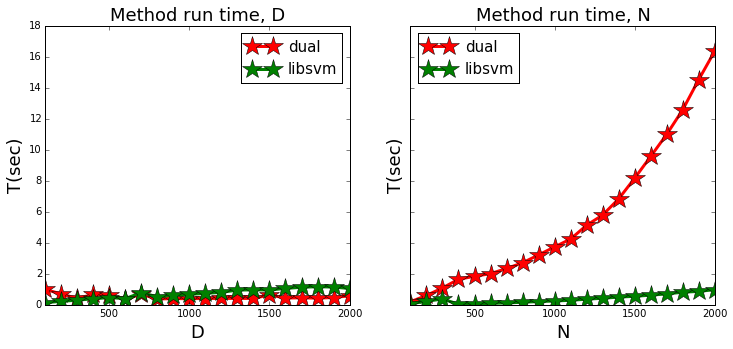

In [24]:
N = 200
D_list = list(range(100, 2100, 100))
y = np.random.choice([-1, 1], size=N)


clf_dual = SVM(method='dual', kernel='rbf')
clf_libsvm = SVM(method='libsvm', kernel='rbf')

time_ = {}
time_['dual'] = []
time_['libsvm'] = []

f, (ax1, ax2) = subplots(1, 2, sharey=True, figsize = (12, 5))

for D in D_list:
    mean = np.zeros(D)
    cov = np.eye(D)
    data = np.random.multivariate_normal(mean, cov, N)
    
    start = time.clock()
    clf_dual.fit(data, y)
    time_['dual'].append(time.clock()-start)
    
    start = time.clock()
    clf_libsvm.fit(data, y)
    time_['libsvm'].append(time.clock()-start)

ax1.plot(D_list, time_['dual'],    lw = 3, marker='*', markersize=20, color = 'red')
ax1.plot(D_list, time_['libsvm'], lw = 3, marker='*', markersize=20, color = 'green')

ax1.legend(['dual', 'libsvm'], loc = 'best', fontsize = 15)
ax1.set_xlabel("D", fontsize = 18)
ax1.set_xlim([min(D_list), max(D_list)])
ax1.set_ylabel('T(sec)', fontsize = 18)
ax1.set_title('Method run time, D', fontsize = 18)

D = 200
mean = np.zeros(D)
cov = np.eye(D)
N_list = list(range(100, 2100, 100))

time_ = {}
time_['dual'] = []
time_['libsvm'] = []

for N in N_list:
    data = np.random.multivariate_normal(mean, cov, N)
    y = np.random.choice([-1, 1], size=N)
    
    start = time.clock()
    clf_dual.fit(data, y)
    time_['dual'].append(time.clock()-start)
    
    start = time.clock()
    clf_libsvm.fit(data, y)
    time_['libsvm'].append(time.clock()-start)

ax2.plot(N_list, time_['dual'],    lw = 3, marker='*', markersize=20, color = 'red')
ax2.plot(N_list, time_['libsvm'], lw = 3, marker='*', markersize=20, color = 'green')

ax2.legend(['dual', 'libsvm'], loc = 'best', fontsize=15)
ax2.set_xlabel("N", fontsize = 18)
ax2.set_xlim(min(N_list), max(N_list))
ax2.set_ylabel('T(sec)', fontsize = 18)
ax2.set_title('Method run time, N', fontsize = 18)

show()

Двойственный метод dual по вышерассмотренным причинам показывает чувствительность к числу объектов в обучающей выборке.

Однако, необходимо заметить, что данные методы в случае линейного ядра работали гораздо медленнее, так как в 
подсчете соответствующей матрицы Грамма использовалось перемножение исходных матриц.

-----

В следующей серии испытаний рассмотрим случаи хорошо и трудно разделимых данных.

Найдем оптимальные параметры для каждого случая, воспользовавшись процедурой simple_search, которая позволяет подобрать 
параметр регуляризации (С) и ширину RBF ядра ($\gamma$), выдавая оценку доли верных предсказаний на кросс-валидации с 5 фолдами.

#### Случай хорошо разделимых данных.

In [268]:
N = 400
D = 2
n = int(N / 4)

data = np.zeros((N, D))
y = np.zeros((N, 1))

data[:, 0][:n] = np.random.normal(loc=2, size=n)
data[:, 1][:n] = np.random.normal(loc=2, size=n)

data[:, 0][n: 2 * n] = np.random.normal(loc=-2, size=n)
data[:, 1][n: 2 * n] = np.random.normal(loc=-2, size=n)

data[:, 0][2 * n: 3 * n] = np.random.normal(loc=2, size=n)
data[:, 1][2 * n: 3 * n] = np.random.normal(loc=-2, size=n)

data[:, 0][3 * n:] = np.random.normal(loc=-2, size=n)
data[:, 1][3 * n:] = np.random.normal(loc=2, size=n)

y = np.ones(N, dtype=int)
y[2 * n:] = -1

Убедимся в том, что построенная выборка действительно удовлетворяет предъявленным на нее требованиям.

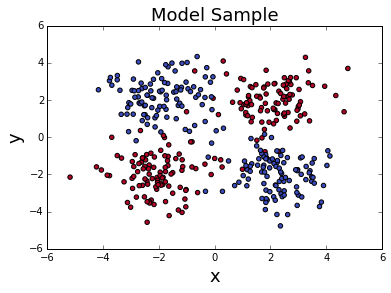

In [269]:
scatter(data[:, 0], data[:, 1], c=y, cmap=plt.cm.coolwarm)
title('Model Sample', fontsize=18)
xlabel('x', fontsize=18)
ylabel('y', fontsize=18)
show()

In [197]:
C_list = 10.0 ** np.arange(-2, 3)
gamma_list = 10.0 ** np.arange(-2, 2)

scores = {'dual': simple_search(data, y, 'dual', 'rbf', C_list, gamma_list), 
          'libsvm' : simple_search(data, y, 'libsvm', 'rbf', C_list, gamma_list)}

print('Best Params')
print('-----------------')
pd.DataFrame(scores).T

Method: dual
-------------------------


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
C,0.01,0.01,0.01,0.01,0.10,0.1000,0.100,0.1,1.00,1.000,1.00,1.00,10.00,10.000,10.0000,10.000,100.0000,100.0000,100.0000,100.0000
gamma,0.01,0.10,1.00,10.00,0.01,0.1000,1.000,10.0,0.01,0.100,1.00,10.00,0.01,0.100,1.0000,10.000,0.0100,0.1000,1.0000,10.0000
mean,0.50,0.50,0.50,0.50,0.50,0.6125,0.605,0.5,0.37,0.805,0.77,0.59,0.45,0.915,0.8175,0.595,0.7775,0.9075,0.8425,0.5825


Method: libsvm
-------------------------


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
C,0.01,0.01,0.01,0.01,0.10,0.1000,0.100,0.1,1.00,1.000,1.00,1.00,10.00,10.000,10.0000,10.000,100.0000,100.000,100.0000,100.0000
gamma,0.01,0.10,1.00,10.00,0.01,0.1000,1.000,10.0,0.01,0.100,1.00,10.00,0.01,0.100,1.0000,10.000,0.0100,0.100,1.0000,10.0000
mean,0.50,0.50,0.50,0.50,0.50,0.6125,0.605,0.5,0.37,0.805,0.77,0.59,0.45,0.915,0.8175,0.595,0.7775,0.905,0.8425,0.5825


Best Params
-----------------


,Accuracy,C,gamma
dual,0.915,10,0.1
libsvm,0.915,10,0.1


Методы libsvm и dual показывают одинаковые результаты на кросс-валидации.

Качество классификации сильно зависит от рассмотренных параметров.

Чем меньше параметр регуляризации, тем сильнее сама регуляризация. Оптиум был достигнут на C = 10. Это означает, что сильного переобучения выявлено не было.

Параметр $\gamma$ отражает силу действия опорных объектов. 
Большие значения параметра $\gamma$ ограничивают действие опорных объектов. Рассматриваются только ближайшие.
Маленькие, наоборот, позволяют расширить радиус действия. Оптиум был достигнут на $\gamma$ = 0.1.

Зафиксируем найденные оптимальные параметры и проведем визуалиацию полученных результатов на примере модели libsvm.

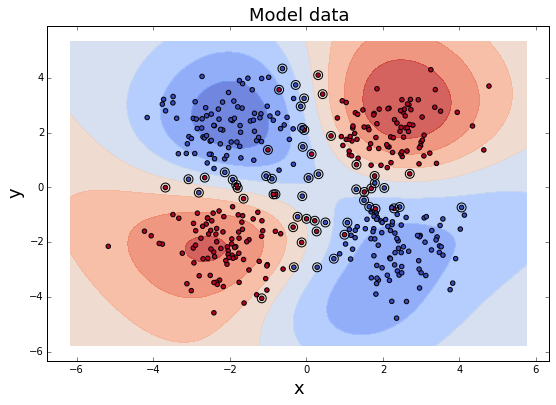

In [279]:
clf = SVM( method='libsvm', C=10, kernel='rbf', gamma=0.1)
clf.fit(data, y)
visualize(data, y, clf, show_vectors=True)

Видно, что модель достаточно неплохо справляется с данными такой природы.

#### Случай трудно разделимых данных.

In [218]:
D = 2
N = 400
mean = np.zeros(D)
cov = np.eye(D)
data = np.random.multivariate_normal(mean, cov, N)
y = np.random.choice([-1, 1], size=N)

Посмотрим на результат.

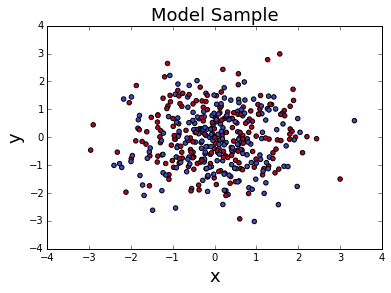

In [219]:
scatter(data[:, 0], data[:, 1], c=y, cmap=plt.cm.coolwarm)
title('Model Sample', fontsize=18)
xlabel('x', fontsize=18)
ylabel('y', fontsize=18)
show()

Выборка действительно является трудно разделимой. Посмотрим, как с таким смогут справится наши модели.

In [220]:
C_list = 10.0 ** np.arange(-2, 3)
gamma_list = 10.0 ** np.arange(-2, 2)

scores = {'dual': simple_search(data, y, 'dual', 'rbf', C_list, gamma_list), 
          'libsvm' : simple_search(data, y, 'libsvm', 'rbf', C_list, gamma_list)}

print('Best Params')
print('-----------------')
pd.DataFrame(scores).T

Method: dual
-------------------------


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
C,0.0100,0.0100,0.0100,0.0100,0.1000,0.1000,0.1000,0.1000,1.0000,1.00,1.0000,1.00,10.00,10.0000,10.000,10.00,100.00,100.00,100.0000,100.0000
gamma,0.0100,0.1000,1.0000,10.0000,0.0100,0.1000,1.0000,10.0000,0.0100,0.10,1.0000,10.00,0.01,0.1000,1.000,10.00,0.01,0.10,1.0000,10.0000
mean,0.5125,0.5125,0.5125,0.5125,0.5125,0.5125,0.5125,0.5125,0.5125,0.51,0.5075,0.49,0.47,0.5025,0.505,0.53,0.46,0.46,0.4925,0.4675


Method: libsvm
-------------------------


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
C,0.0100,0.0100,0.0100,0.0100,0.1000,0.1000,0.1000,0.1000,1.0000,1.00,1.0000,1.00,10.00,10.0000,10.0000,10.000,100.00,100.000,100.00,100.00
gamma,0.0100,0.1000,1.0000,10.0000,0.0100,0.1000,1.0000,10.0000,0.0100,0.10,1.0000,10.00,0.01,0.1000,1.0000,10.000,0.01,0.100,1.00,10.00
mean,0.5125,0.5125,0.5125,0.5125,0.5125,0.5125,0.5125,0.5125,0.5125,0.51,0.5075,0.49,0.47,0.5025,0.5325,0.535,0.46,0.475,0.49,0.48


Best Params
-----------------


,Accuracy,C,gamma
dual,0.530,10,10
libsvm,0.535,10,10


Как и предполагалось, классифицировать такие данные SVM отказывается.

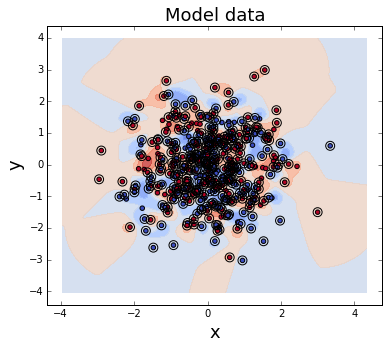

In [222]:
clf = SVM( method='libsvm', C=10, kernel='rbf', gamma=10)
clf.fit(data, y)
visualize(data, y, clf, show_vectors=True)

Высокое значение параметра $\gamma$ соответствует данному графику.

-----

Настоящие испытания будут основаны на сравнении стратегий выбора шага в методе субградиентного спуска.

Рассмотрим следующие варианты: $$\alpha, \frac{\alpha}{t}, \frac{\alpha}{t^\beta}$$
    $\alpha, \beta$ - некоторые константы, $t$ - номер итерации.

Оценим скорость сходимости и точность решения.

В качестве модельных данных рассмотрим  линейно разделимую выборку.

In [412]:
N = 400
D = 2
n = int(N / 2)

data = np.zeros((N, D))
y = np.zeros((N, 1))

data[:, 0][:n] = np.random.normal(loc=2, size=n)
data[:, 1][:n] = np.random.normal(loc=2, size=n)

data[:, 0][n:] = np.random.normal(loc=-2, size=n)
data[:, 1][n:] = np.random.normal(loc=-2, size=n)

y = np.ones(N, dtype=int)
y[n:] = -1

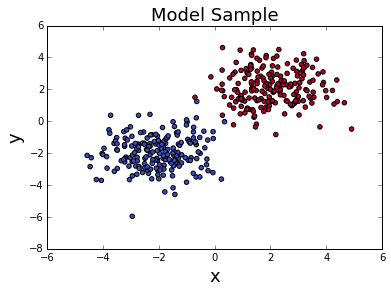

In [413]:
scatter(data[:, 0], data[:, 1], c=y, cmap=plt.cm.coolwarm)
title('Model Sample', fontsize=18)
xlabel('x', fontsize=18)
ylabel('y', fontsize=18)
show()

Для оценки точности решения выделим валидационную выборку.

In [414]:
X_train, X_test, y_train, y_test = \
                          train_test_split(data, y, test_size=0.3, random_state=241)

In [415]:
scores = {}
clf = SVM(method='subgradient')

info = clf.fit(X_train, y_train, alpha=0.5, beta=0.0)

scores['alpha'] = \
  { 'n_iter': len(info['objective_curve']) - 1, 
    'Accuracy' : accuracy_score(
                  y_test,
                  clf.predict(
                     X_test,
                     return_classes=True))
  }
    
info = clf.fit(X_train, y_train, alpha=0.5, beta=1.0)

scores['alpha/t'] = \
  { 'n_iter': len(info['objective_curve']) - 1, 
    'Accuracy' : accuracy_score(
                  y_test,
                  clf.predict(
                     X_test,
                     return_classes=True))
  }

info = clf.fit(X_train, y_train, alpha=0.5, beta=0.5) 

scores['alpha/t^beta'] = \
  { 'n_iter': len(info['objective_curve']) - 1, 
    'Accuracy' : accuracy_score(
                  y_test,
                  clf.predict(
                     X_test,
                     return_classes=True))
  }
    
pd.DataFrame(scores).T

,Accuracy,n_iter
alpha,0.983333,1000
alpha/t,0.983333,252
alpha/t^beta,0.975000,36


Самой лучшей оказалась стратегия $\frac{\alpha}{t}$.

Для сходимости требуется небольшое количество итераций, обеспечивает самую качественную классификацию.

Зафиксируем выбранную стратегию шага и осуществим визуализацию полученных результатов.

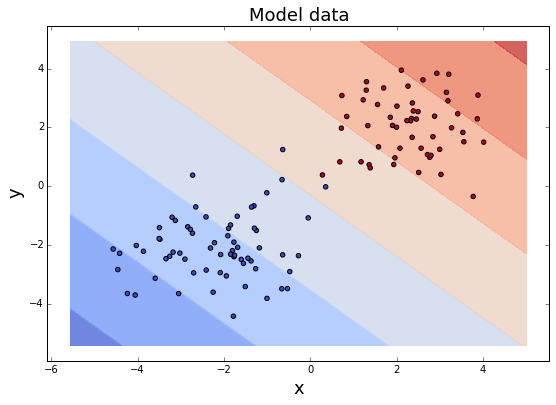

In [416]:
clf = SVM( method='stoch_subgradient')
clf.fit(X_train, y_train)
visualize(X_test, y_test, clf, show_vectors=True)

----

В последней серии испытаний будем исследовать, как размер подвыборки, по которой считается субградиент,
в методе стохастического субградиентного спуска влияет на скорость сходимости и на точность решения.

В качестве модельных данных возьмем используемую в прошлой серии испытаний линейно разделимую выборку.


In [360]:
scores = []
iterations = []
N_max = X_train.shape[0]

size_list = list(range(1, N_max, 10))
size_list.append(N_max)

clf = SVM(method='stoch_subgradient')

for size in size_list:
    
    info = clf.fit(X_train, y_train, batch_size=size)
    scores.append(
           accuracy_score(
             y_test,
             clf.predict(
                X_test,
                return_classes=True)))
    iterations.append(len(info['objective_curve']) - 1)

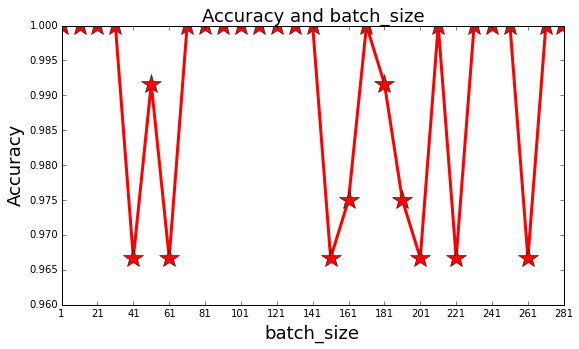

In [375]:
figure(figsize=(9, 5))

plot(size_list, scores, lw = 3, marker='*', markersize=20, color = 'red')
xlabel("batch_size", fontsize = 18)
xlim([min(size_list), max(size_list)])
xticks(np.arange(min(size_list), max(size_list) + 10, 20))
ylim([0.96, 1])
ylabel('Accuracy', fontsize = 18)
title('Accuracy and batch_size', fontsize = 18)

show()

В методе стохастического градиентного спуска на каждой итерации выбирается случайная подвыборка, размера batch_size.

В виду наличия случайности в эксперименте, график имеет не монотонную зависимость.

Между тем, на всем подмножестве объектов достигается максимальная точность.

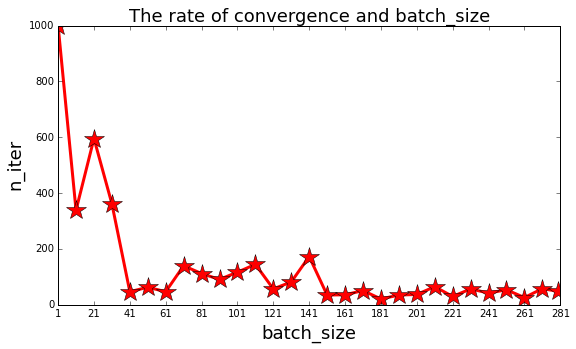

In [374]:
figure(figsize=(9, 5))

plot(size_list, iterations, lw = 3, marker='*', markersize=20, color = 'red')
xlabel("batch_size", fontsize = 18)
xlim([min(size_list), max(size_list)])
xticks(np.arange(min(size_list), max(size_list) + 10, 20))
ylabel('n_iter', fontsize = 18)
title('The rate of convergence and batch_size', fontsize = 18)

show()

Число итераций, необходимое для сходимости метода, естественным образом монотонно зависит от размера подвыборки.

Скорость сходимости субградиентного спуска выше, чем у его стохастического аналога.

Максимальный batch_size, представленный на графике, соответствует размеру всей выборки.
Иными словами, стохастический вариант переходит в обычный субградиентный спуск.